Loading the Kedro extension for IPython

In [17]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


Installation of libraries

In [18]:
!pip install tpot
!pip install imbalanced-learn
!pip install graphviz
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import joblib





Loading the DataFrame

In [20]:
games_new = catalog.load("games_new")

[11/10/24 18:28:02] INFO     Loading data from games_new (CSVDataset)...                        ]8;id=548914;file://c:\Users\diego\OneDrive\Documentos\Kedro\metagames_kedro\env\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=149300;file://c:\Users\diego\OneDrive\Documentos\Kedro\metagames_kedro\env\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

# Phase 4: Modeling

## Analysis of variable distribution


The first thing we will do is visualize the distribution of the data using graphs. This will help us identify initial patterns, detect outliers, and ensure that the data makes sense for the model.

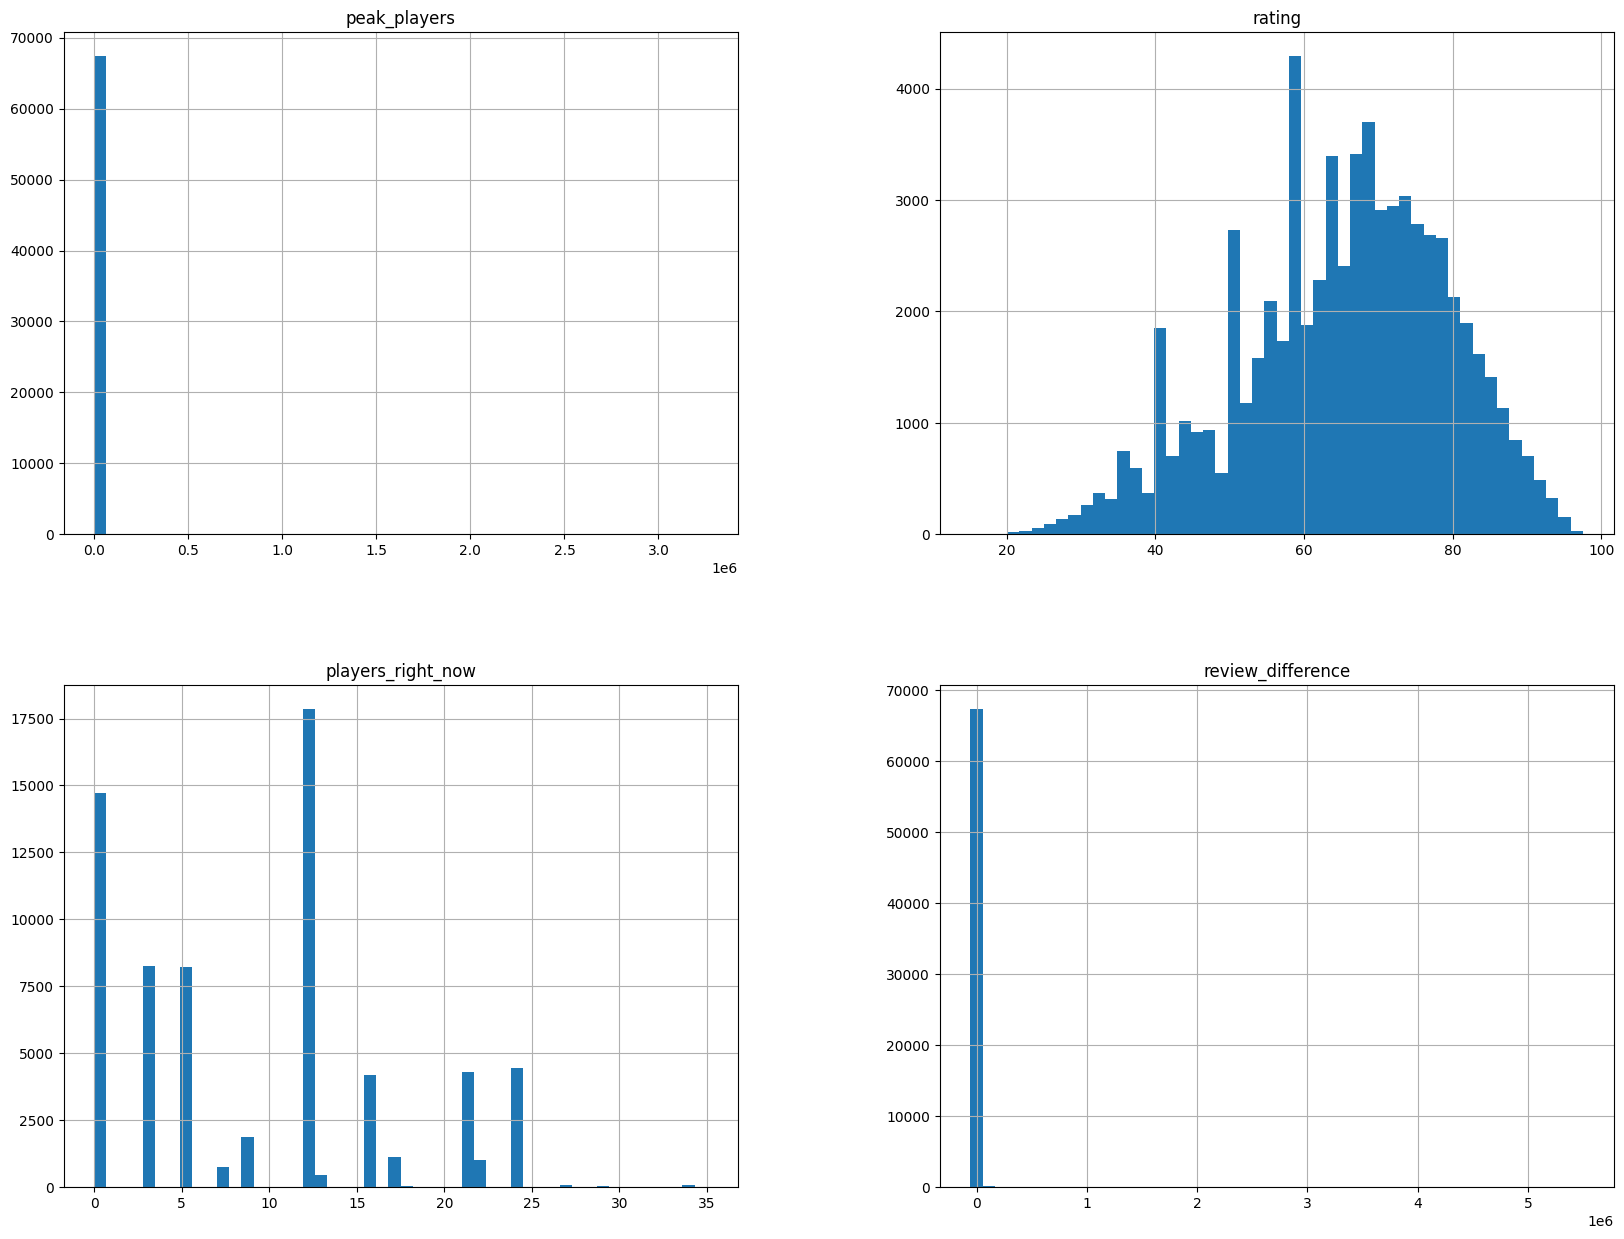

In [21]:
#We create a histogram for the variables of games_new.
games_new.hist(bins=50, figsize=(20,15))
plt.show()

The analysis of the histograms reveals several important characteristics about the distribution of the data. In the peak_players variable, most games have a relatively low maximum number of players, while a few titles reach extremely high figures, indicating the presence of outliers corresponding to very popular games. A similar pattern occurs in players_right_now, where most games have few active players, but some peak between 10,000 and 15,000 players, suggesting a marked disparity in real-time popularity. The review_difference variable also shows a high concentration of low values, with a few games having very positive review differences, which could be a key metric for identifying well-received titles. On the other hand, rating exhibits an approximately normal and symmetrical distribution centered around 60 points, indicating a moderately positive rating for most games and suggesting that this variable will likely not require adjustments in modeling.





## Handling Outliers


Since several variables have outliers that may negatively affect the model's performance, we implemented a treatment for these extreme values using capping at the 99th percentile. This method reduces the impact of outliers without removing data, limiting the values of the variables beyond a certain threshold and thus ensuring greater stability and generalization of the model.


Next, the code used to calculate the 99th percentile of each column and apply the capping is shown.

In [22]:
print(games_new.dtypes)

game                  object
release               object
peak_players           int64
rating               float64
primary_genre         object
developer             object
players_right_now    float64
review_difference      int64
dtype: object


In [23]:
#We define the 99th percentile for each variable.
peak_players_cap = games_new['peak_players'].quantile(0.99)
players_right_now_cap = games_new['players_right_now'].quantile(0.99)
review_difference_cap = games_new['review_difference'].quantile(0.99)

#We apply the capping of values at the 99th percentile.
games_new['peak_players'] = np.where(games_new['peak_players'] > peak_players_cap, peak_players_cap, games_new['peak_players'])
games_new['players_right_now'] = np.where(games_new['players_right_now'] > players_right_now_cap, players_right_now_cap, games_new['players_right_now'])
games_new['review_difference'] = np.where(games_new['review_difference'] > review_difference_cap, review_difference_cap, games_new['review_difference'])



By implementing this capping method, extreme values are limited without removing them from the dataset. This improves the representativeness and stability of the model by reducing the influence of outliers that could skew the results.

# Regression Model

## Splitting the Dataset


To build a regression model that predicts the level of recommendation for a game (represented by the target variable rating), it is essential to split the dataset into two subsets: training and testing. This division allows the model to be trained on one part of the data and evaluated on data it has not seen before, ensuring that the model generalizes well and is not overfitting.


The typical split is 80% of the data for training and 20% for testing. This allows us to train the model effectively and fairly evaluate its accuracy on data that simulates new observations.

In [24]:
#Define features (X) and target variable (y)
X = games_new.drop(['rating', 'game', 'release', 'developer', 'primary_genre'], axis=1)  #Remove irrelevant columns for prediction
y = games_new['rating']

#Split the dataset into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Verify the shapes of the sets to ensure that the split is correct
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (54056, 3)
Shape of y_train: (54056,)
Shape of X_test: (13515, 3)
Shape of y_test: (13515,)


## Normalization of the variable players_right_now

The variable players_right_now exhibits a uniform distribution with values ranging from 0 to 40,000 active players at any given moment. Due to its wide range and the presence of large values, this variable is likely to have a disproportionate weight in predictive models. To mitigate this effect and improve the scalability of the data, we decided to apply normalization using the Min-Max method, scaling the values of players_right_now to a range of 0 to 1.

In [25]:
scaler = MinMaxScaler()
games_new['players_right_now'] = scaler.fit_transform(games_new[['players_right_now']])

## Remove Irrelevant Features

We will use feature selection methods like feature_importances_ from RandomForest to remove features that do not add value, which can enhance the performance of TPOT.




In [26]:
selector = SelectKBest(score_func=f_regression, k=10)  #Select the top 10 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


[11/10/24 18:28:03] WARNING  c:\Users\diego\OneDrive\Documentos\Kedro\metagames_kedro\env\Lib\site- ]8;id=211959;file://C:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=537043;file://C:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             packages\sklearn\feature_selection\_univariate_selection.py:776:                      
                             UserWarning: k=10 is greater than n_features=3. All the features will                 
                             be returned.                                                                          
                               warnings.warn(                                                                      
                                                                                                                   

## Implementation of Config_Dict

Using config_dict will allow us to better leverage resources and make TPOT work more efficiently in finding an optimal model for your data.

In [27]:
#Definition of config_dict
custom_config_dict = {
    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_features': [0.8, 0.9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'xgboost.XGBRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'objective': ['reg:squarederror']
    }
}


## Training the Regression Model with TPOT




Let's continue with the training process. TPOT will test various model configurations and optimize them to find the best fit for your data. Once we have our training and testing sets ready, we can use TPOT to train the model.

We will run our block again after normalizing the data and removing irrelevant features, but this time with generations=10 and population_size=50 to allow TPOT to explore more model configurations.


In [28]:
#Create and train the TPOTRegressor with config_dict
tpot = TPOTRegressor(config_dict=custom_config_dict, verbosity=2, generations=10, population_size=50, random_state=42)
tpot.fit(X_train, y_train)

# Make predictions and calculate the error on the testing set
y_pred = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Root mean square error on test set:", mse)

# Export the best pipeline
tpot.export('best_pipeline_regressor.py')

                                                                                
Generation 1 - Current best internal CV score: -28.5573658449655
                                                                                
Generation 2 - Current best internal CV score: -28.504909993923597
                                                                                  
Generation 3 - Current best internal CV score: -28.504909993923597
                                                                                  
Generation 4 - Current best internal CV score: -28.504909993923597
                                                                                  
Generation 5 - Current best internal CV score: -28.504909993923597
                                                                                  
Generation 6 - Current best internal CV score: -28.504909993923597
                                                                                  
Generation 7 - Current 

In this analysis, the generated results show a progressive improvement in the internal cross-validation (CV) scores across multiple generations in the search for the optimal model with TPOT. In the end, the chosen model was an XGBRegressor, a high-performance implementation of gradient boosting selected after ten generations of optimization, achieving the following results:

- **Improvement of Cross-Validation Score:** The internal CV score, represented as a negative value (in terms of negative mean squared error), has gradually decreased. This indicates that TPOT has been optimizing the model, refining its hyperparameters to minimize the error. Initially, the best score was approximately -28.56, improving to a final value of -28.50 in the second generation and remaining stable until the end, suggesting that TPOT quickly reached a stable and optimal model.

- **Mean Squared Error on the Testing Set:** MSE on test: 27.72: This value represents the average of the squared differences between the predictions and the actual values in the testing set. The lower the value, the better the model fit, and in this case, it indicates relatively good performance.





## XGBRegressor Regression Model


First, we scale the training and testing data, as XGBRegressor can benefit from standardization to improve stability and training speed.

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Next, we define XGBRegressor as the base regression model. We set up a hyperparameter space (n_estimators, max_depth, learning_rate, subsample, and min_child_weight) for GridSearchCV to explore the best combinations using 5-fold cross-validation, minimizing the mean squared error. We train the model with GridSearchCV, obtaining the best set of hyperparameters and the optimized model. Finally, we evaluate the model on the testing set and display the metrics to assess its performance.

In [ ]:
# 1. Define the model
# We use XGBRegressor as the base model.
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# 2. Define the hyperparameter space for optimization
# Include several values for n_estimators, max_depth, learning_rate, subsample, and min_child_weight
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}

# 3. We define the Grid Search with cross-validation.
# We configure GridSearchCV to optimize the hyperparameters using 5-fold cross-validation and negative mean squared error as the metric.
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores.
)

# 4. We train the model using Grid Search.
# We fit GridSearchCV on the scaled training data.
grid_search.fit(X_train_scaled, y_train)

# 5. We obtain the best parameters and the optimized model.
# Once the fitting is complete, we extract the best hyperparameters and the optimized model.
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 6. We make predictions and evaluate the model on the testing set.
# We use the optimized model to make predictions and calculate performance metrics.
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 7. Imprimimos las métricas de evaluación
print(f"\nMean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}

Mean Squared Error (MSE): 27.720219507193924
Mean Absolute Error (MAE): 4.111025477593889
R^2 Score: 0.8601359404834644



The hyperparameter tuning process explored 162 different combinations through 5 folds of cross-validation, resulting in a total of 810 fits, successfully identifying an optimal configuration with well-selected parameters. The final combination, which includes a learning_rate of 0.1, a max_depth of 6, and a subsample of 1.0, indicates that the model was designed to capture complex relationships without overfitting. The results show a Mean Squared Error (MSE) of 27.72 and a Mean Absolute Error (MAE) of 4.11, suggesting that the model maintains a low prediction error overall. Additionally, an R² of 0.86 reveals that the model explains approximately 86% of the variability in the data, indicating a strong fit. Together, these results suggest that the model performs effectively in terms of accuracy and generalization.

## Scatter Plot of XGBRegressor Regression Model

We will create a scatter plot that shows the comparison between the actual values and the model's predictions, using Matplotlib. This plot is useful for visualizing how close the predictions are to the actual values and thus evaluating the performance of your model.

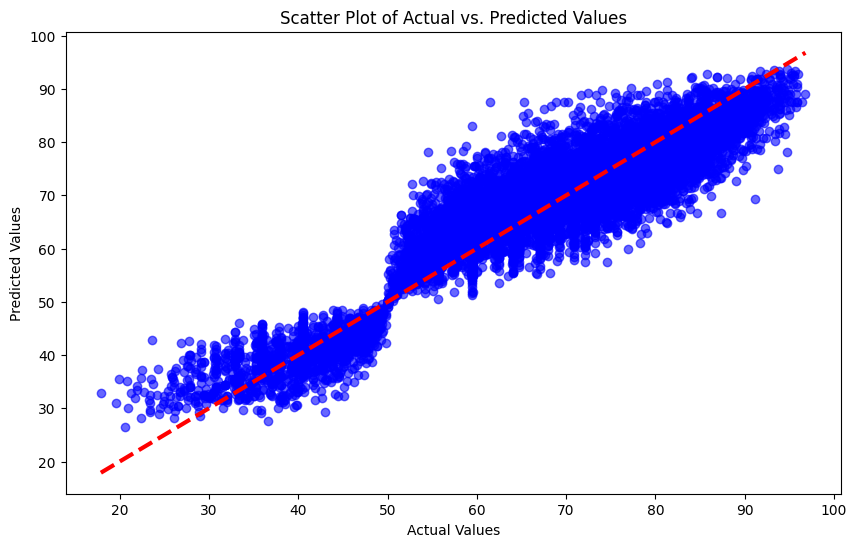

In [ ]:
# We make predictions on the testing set.
y_pred = best_model.predict(X_test_scaled)

# We create the scatter plot.
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')  # Scatter plot of actual vs. predicted values.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)  # Ideal line for perfect prediction.
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Actual vs. Predicted Values")
plt.show()

**General Accuracy:** Most points are close to the fitting line, indicating that the model makes accurate predictions overall.

**Relationship Capture:** The clear diagonal trend suggests that the model adequately captures the relationship between actual values and predictions.

**Dispersion at Extremes:** Some dispersion is observed at the upper and lower extremes, which may indicate that the model does not capture all the details in those ranges.

**Overfitting/Underfitting Assessment:** The closeness to the line indicates that the model is neither severely overfitted nor underfitted, although it's important to review metrics like MSE and R².

## RandomForestRegressor Regression Model

This code adjusts the hyperparameters of RandomForestRegressor to find the best values using GridSearchCV. It then makes predictions and evaluates the model's performance using the testing set, calculating the MSE, MAE, and R².

In [ ]:
# 1. We define the model.
# We use RandomForestRegressor as the base model.
rf_model = RandomForestRegressor(random_state=42)

# 2. We define the hyperparameter space for optimization.
# We include several values for n_estimators, max_depth, max_features, and min_samples_split.
# We adjusted the hyperparameter space to avoid the error with 'max_features'.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}


# 3. We define grid search with cross-validation
# We configured GridSearchCV to optimize hyperparameters using 5-fold cross-validation and neg_mean_squared_error as the metric.
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# 4. We train the model using Grid Search
# We tune the GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# 5. We obtain the best parameters and the optimized model
# Once the tuning is finished, we extract the best hyperparameters and the optimized model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 6. We make predictions and evaluate the model on the test set
# We use the optimized model to predict and calculate performance metrics
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 7. We print the evaluation metrics
print(f"\nMean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}

Mean Squared Error (MSE): 29.18673516163437
Mean Absolute Error (MAE): 4.260832189088945
R^2 Score: 0.852736546235473


Hyperparameter tuning of the RandomForestRegressor model found that the best parameters were max_depth=10, max_features='sqrt', min_samples_split=5, and n_estimators=200. With this optimized model, the results obtained on the test set include a mean square error (MSE) of 29.19, a mean absolute error (MAE) of 4.26, and a coefficient of determination (R²) of 0.85. This indicates that the model has good overall performance, capturing 85.3% of the variability in the test data, although there is still room for improvement in accuracy in the extreme values.

## RandomForestRegressor Regression Model Scatter Plot

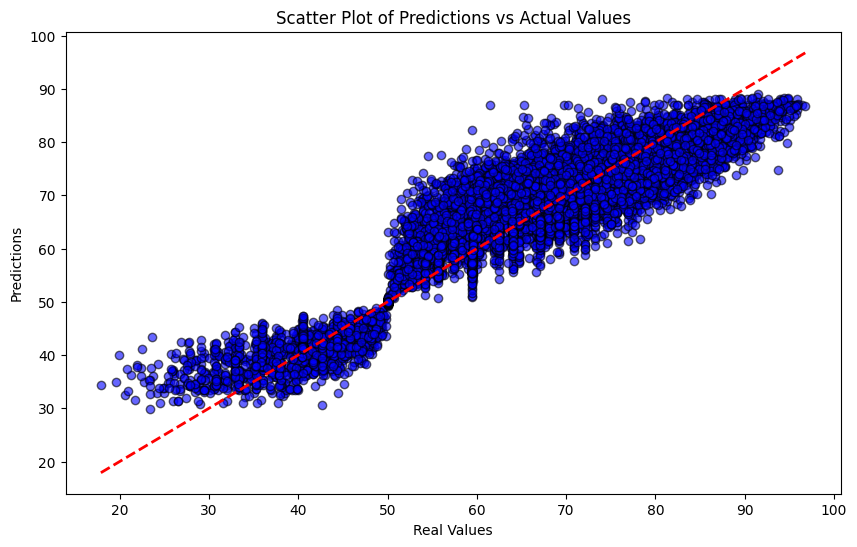

In [ ]:
# Generate the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal line of perfect prediction
plt.xlabel("Real Values")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Predictions vs Actual Values")
plt.show()


The scatterplot shows an overall positive relationship between actual values ​​and predictions, as most of the points are aligned near the red diagonal line (representing a perfect prediction). However, significant dispersion can also be noted as values ​​increase, especially in the actual value range of 50 to 80, where predictions have more variability and tend to deviate from the ideal line. This indicates that the model performs well in general, but still presents prediction errors in certain ranges, which could suggest the possibility of adjusting or improving the model to achieve greater accuracy in those cases.

## GradientBostingRegressor Regression Model

This code performs the same steps as the previous model but using GradientBoostingRegressor. The learning_rate and n_estimators hyperparameters are key in the Gradient Boosting model, and have been included in the optimization.

In [ ]:
# 1. We define the model
# We use GradientBoostingRegressor as the base model
gb_model = GradientBoostingRegressor(random_state=42)

# 2. We define the hyperparameter space for optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10]
}

# 3. We define Grid Search with cross validation
# We configure the GridSearchCV to optimize the hyperparameters using 5-fold cross-validation and neg_mean_squared_error as the metric
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# 4. We train the model using Grid Search
# We tune the GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# 5. We obtain the best parameters and the optimized model
# Once the tuning is finished, we extract the best hyperparameters and the optimized model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 6. We make predictions and evaluate the model on the test set
# We use the optimized model to predict and calculate performance metrics
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 7. We print the evaluation metrics
print(f"\nMean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 100}

Mean Squared Error (MSE): 27.715645635525973
Mean Absolute Error (MAE): 4.113723764309625
R^2 Score: 0.8601590182321461


## GradientBostingRgressor Regression Model Scatter Plot

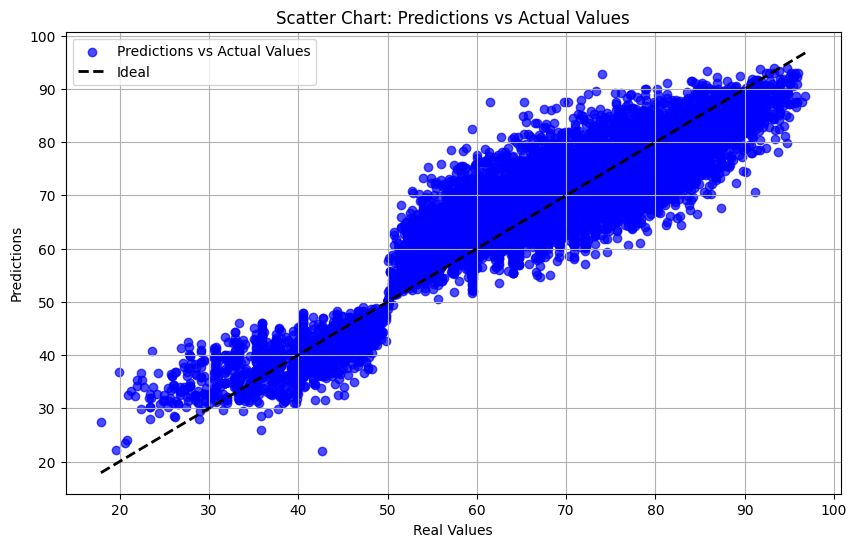

In [ ]:
# Crear gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label='Predictions vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Scatter Chart: Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()